Pipelines: Mass Total + Source Inversion
========================================

Using a pipeline composed of three searches this runner fits strong lens `Imaging`, where in the final phase
of the pipeline:
.
 - The lens galaxy's light is omitted from the data and model.
 - The lens galaxy's total mass distribution is an input total `MassProfile` (default=`EllipticalPowerLaw`).
 - The source galaxy is an `Inversion`.

This uses the pipeline (Check it out full description of the pipeline):

 `autolens_workspace/notebooks/advanced/pipelines/mass_power_law__source_inversion.py`.

In [1]:
%matplotlib inline
from pyprojroot import here
workspace_path = str(here())
%cd $workspace_path
print(f"Working Directory has been set to `{workspace_path}`")

from os import path
import autolens as al
import autolens.plot as aplt

dataset_name = "mass_sie__source_sersic_x2"
pixel_scales = 0.1

dataset_path = path.join("dataset", "imaging", "no_lens_light", dataset_name)

/mnt/c/Users/Jammy/Code/PyAuto/autolens_workspace
Working Directory has been set to `/mnt/c/Users/Jammy/Code/PyAuto/autolens_workspace`


Using the dataset path, load the data (image, noise-map, PSF) as an `Imaging` object from .fits files.

In [2]:
imaging = al.Imaging.from_fits(
    image_path=path.join(dataset_path, "image.fits"),
    psf_path=path.join(dataset_path, "psf.fits"),
    noise_map_path=path.join(dataset_path, "noise_map.fits"),
    pixel_scales=pixel_scales,
)

Next, we create the mask we'll fit this data-set with.

In [3]:
mask = al.Mask2D.circular(
    shape_native=imaging.shape_native, pixel_scales=imaging.pixel_scales, radius=3.0
)

Make a quick subplot to make sure the data looks as we expect.

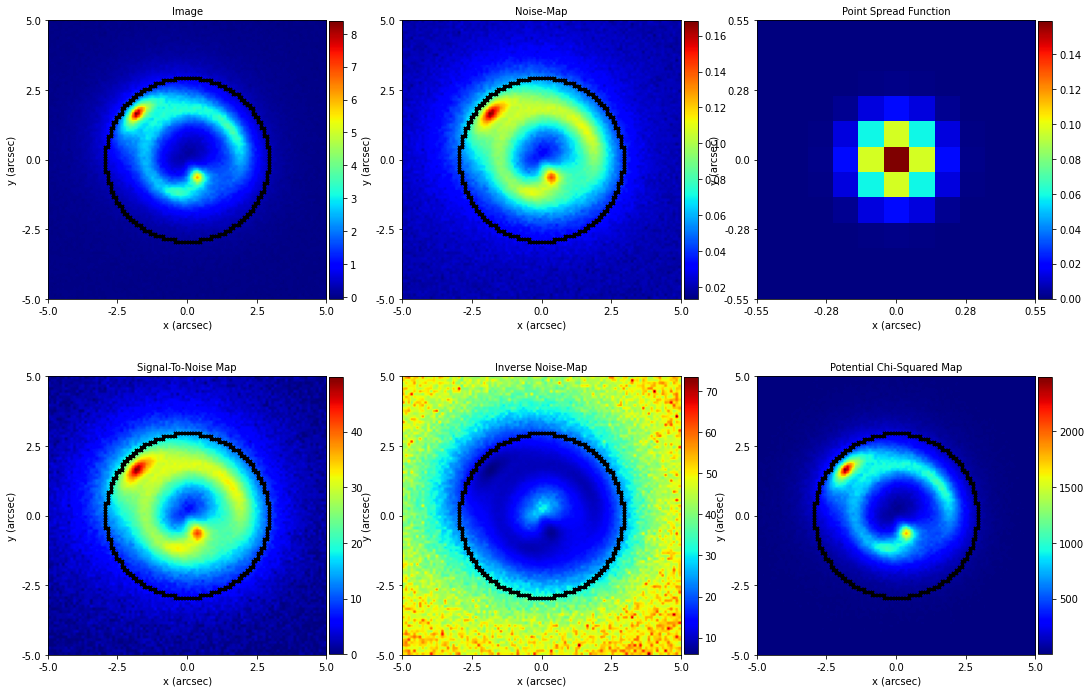

In [4]:
imaging_plotter = aplt.ImagingPlotter(
    imaging=imaging, visuals_2d=aplt.Visuals2D(mask=mask)
)
imaging_plotter.subplot_imaging()

__Settings__

The `SettingsPhaseImaging` describe how the model is fitted to the data in the log likelihood function.

These settings are used and described throughout the `autolens_workspace/notebooks/imaging/modeling` example scripts, with a 
complete description of all settings given in `autolens_workspace/notebooks/imaging/modeling/customize/settings.py`.

The settings chosen here are applied to all searches in the pipeline.

In [5]:
settings_masked_imaging = al.SettingsMaskedImaging(grid_class=al.Grid2D, sub_size=2)

`Inversion`'s may infer unphysical solution where the source reconstruction is a demagnified reconstruction of the 
lensed source (see **HowToLens** chapter 4). 

To prevent this, auto-positioning is used, which uses the lens mass model of earlier searches to automatically set 
positions and a threshold that resample inaccurate mass models (see `notebooks/imaging/modeling/positions.py`).

The `auto_positions_factor` is a factor that the threshold of the inferred positions using the previous mass model are 
multiplied by to set the threshold in the next phase. The *auto_positions_minimum_threshold* is the minimum value this
threshold can go to, even after multiplication.

In [6]:
settings_lens = al.SettingsLens(
    auto_positions_factor=3.0, auto_positions_minimum_threshold=0.8
)

settings = al.SettingsPhaseImaging(
    settings_masked_imaging=settings_masked_imaging, settings_lens=settings_lens
)

__Pipeline_Setup__:

Pipelines use `Setup` objects to customize how different aspects of the model are fitted. 

First, we create a `SetupMassTotal`, which customizes:

 - The `MassProfile` used to fit the lens's total mass distribution.
 - If there is an `ExternalShear` in the mass model or not.

In [7]:
setup_mass = al.SetupMassTotal(
    mass_prior_model=al.mp.EllipticalPowerLaw, with_shear=True
)

Next, we create a `SetupSourceInversion` which customizes:

 - The `Pixelization` used by the `Inversion` in search 2 onwards in the pipeline.
 - The `Regularization` scheme used by the `Inversion` in search 3 onwards in the pipeline.

In [8]:
setup_source = al.SetupSourceInversion(
    pixelization_prior_model=al.pix.VoronoiMagnification,
    regularization_prior_model=al.reg.Constant,
)

_Pipeline Tagging_

The `Setup` objects are input into a `SetupPipeline` object, which is passed into the pipeline and used to customize
the analysis depending on the setup. This includes tagging the output path of a pipeline. For example, if `with_shear` 
is True, the pipeline`s output paths are `tagged` with the string `with_shear`.

This means you can run the same pipeline on the same data twice (e.g. with and without shear) and the results will go
to different output folders and thus not clash with one another!

The `path_prefix` below specifies the path the pipeline results are written to, which is:

 `autolens_workspace/output/imaging/modeling/pipelines/no_lens_light/dataset_type/dataset_name` 
 `autolens_workspace/output/imaging/modeling/pipelines/no_lens_light/mass_sie__source_sersic_x2`
 
The redshift of the lens and source galaxies are also input (see `notebooks/imaging/modeling/customize/redshift.py`) for a 
description of what inputting redshifts into **PyAutoLens** does.

In [9]:
setup = al.SetupPipeline(
    path_prefix=path.join("imaging", "pipelines", "no_lens_light", dataset_name),
    redshift_lens=0.5,
    redshift_source=1.0,
    setup_mass=setup_mass,
    setup_source=setup_source,
)

__Pipeline Creation__

To create a pipeline we import it from the pipelines folder and run its `make_pipeline` function, inputting the 
`Setup` and `SettingsPhase` above.

In [10]:
from pipelines import mass_total__source_inversion

pipeline = mass_total__source_inversion.make_pipeline(setup=setup, settings=settings)

__Pipeline Run__

Running a pipeline is the same as running a phase, we simply pass it our lens dataset and mask to its run function.

In [11]:
pipeline.run(dataset=imaging, mask=mask)

INFO:autofit.tools.pipeline:Running Phase phase[1]_mass[sie]_source[bulge] (Number 0)
INFO:root:phase[1]_mass[sie]_source[bulge] already completed, skipping non-linear search.
INFO:autofit.tools.pipeline:Running Phase phase[2]_mass[sie]_source[inversion_initialization] (Number 1)
INFO:root:phase[2]_mass[sie]_source[inversion_initialization] already completed, skipping non-linear search.
INFO:autofit.tools.pipeline:Running Phase phase[3]_mass[sie]_source[inversion] (Number 2)
/home/jammy/venvs/PyAuto/lib/python3.8/site-packages/numba/core/ir_utils.py:2067: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'slim_indexes' of function 'furthest_grid_2d_slim_index_from'.

For more information visit https://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "../PyAutoArray/autoarray/structures/grids/two_d/grid_2d_util.py", line 673:
@decora

Finish.